In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import soundfile as sf

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.5)

Usando dispositivo: cuda


In [2]:
MAX_LEN = 660000//6
SR = 22050
T0 = MAX_LEN/22050

X = []
y = []
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for id, genre in enumerate(genres):
    for i in range(100):
        if not (i == 54 and genre == 'jazz'):
            x, _ = sf.read(f'../Data/genres_original/{genre}/{genre}.000{i:02}.wav')
            X.append(x[MAX_LEN:2*MAX_LEN])
            y.append(id)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28, stratify=y
)
del X

print(f"Entrenamiento: {len(X_train)} pares")
print(f"Validación: {len(X_test)} pares")

Entrenamiento: 799 pares
Validación: 200 pares


In [4]:
F.one_hot(torch.tensor(3), 10)

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [5]:
class audiodataset(Dataset):
    def __init__(self, X, y):
        self.pairs = list(zip(X, y))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        xs, ys = self.pairs[idx]

        return {
            'input': torch.tensor(xs).to(device),
            'target': F.one_hot(torch.tensor(ys), 10).to(device=device, dtype=torch.float64),
            'input_length': len(xs),
            'target_length': 10
        }

train_dataset = audiodataset(X_train, y_train)
test_dataset = audiodataset(X_test, y_test)

In [6]:
train_dataset[2]

{'input': tensor([-0.5208, -0.3644, -0.1389,  ...,  0.0835,  0.0625,  0.0831],
        device='cuda:0', dtype=torch.float64),
 'target': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0',
        dtype=torch.float64),
 'input_length': 110000,
 'target_length': 10}

### Modelo naive

In [7]:
class modelo1(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.capa1 = nn.Linear(input_size, 200, dtype=torch.float64)
        self.capa2 = nn.Linear(200, 50, dtype=torch.float64)
        self.capa3 = nn.Linear(50, 10, dtype=torch.float64)
        self.tanh = torch.tanh

    def forward(self, input):
        out = self.tanh(self.capa1(input))
        out = self.tanh(self.capa2(out))
        out = self.capa3(out)
        return out.to(device)

In [8]:
# hiperparametros
INPUT_DIM = train_dataset[0]['input_length']
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

model = modelo1(INPUT_DIM).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 22010760 parámetros


In [9]:
train_losses = []
val_losses = []

print("Iniciando entrenamiento...")
print("-" * 50)

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    model.train()
    train_loss = 0
    for item in train_dataset:
        input = item['input']
        target = item['target']

        optimizer.zero_grad()

        output = model.forward(input)
        loss = criterion(output, target)
        
        loss.backward()

        # Gradient clipping para evitar exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for item in test_dataset:
            input = item['input']
            target = item['target']

            output = model.forward(input)
            loss = criterion(output, target)
            val_loss += loss.item()
    val_loss /= len(train_dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Época {epoch+1}/{NUM_EPOCHS}')
        print(f'  Pérdida Entrenamiento: {train_loss:.4f}')
        print(f'  Pérdida Validación: {val_loss:.4f}')
        print(f'  {"Mejorando" if val_loss < min(val_losses[:-1] + [float("inf")]) else "Empeorando"}')

print("Entrenamiento completado!")

Iniciando entrenamiento...
--------------------------------------------------
Época 5/20
  Pérdida Entrenamiento: 0.1262
  Pérdida Validación: 1.2010
  Empeorando
Época 10/20
  Pérdida Entrenamiento: 0.0005
  Pérdida Validación: 1.4706
  Empeorando
Época 15/20
  Pérdida Entrenamiento: 0.0001
  Pérdida Validación: 1.6501
  Empeorando
Época 20/20
  Pérdida Entrenamiento: 0.0000
  Pérdida Validación: 1.8398
  Empeorando
Entrenamiento completado!


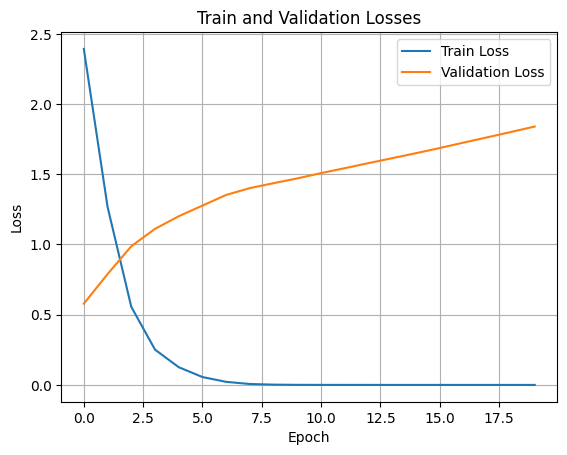

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# accuracy

model.eval()
accur = 0
with torch.no_grad():
    for item in test_dataset:
        input = item['input']
        target = item['target']

        output = model.forward(input)
        pred = F.one_hot(torch.argmax(output), 10)

        accur += int(sum(target == pred) == 10)

accur /= len(train_dataset)
print(f'Accuracy con los datos de validacion {accur:.4f}')

Accuracy con los datos de validacion 0.2503
